<a href="https://colab.research.google.com/github/flohmannjr/PJI410/blob/main/PJI410_sintomas_covid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PJI410 - Classificação de diagnóstico de COVID-19 a partir de sintomas e fatores de risco

# Importações

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import GridSearchCV, train_test_split

from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from xgboost import XGBClassifier

import tensorflow as tf

from tensorflow.data import AUTOTUNE, Dataset
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

# Configurações

In [2]:
plt.rcParams['figure.figsize'] = [8, 5]
plt.rcParams['figure.dpi']     = 100

# plt.style.use('seaborn-darkgrid')
# plt.style.use('seaborn-v0_8-darkgrid')
sns.set_style("darkgrid")

SEMENTE = 2001088 + 2001247 + 2003061 + 2005493 + 2008193 + 2008620 + 2008880

PALETA = 'summer_r'

## Hiperparâmetros

In [3]:
LOTE_TAMANHO = 2048

CAMADAS = 4

CAMADA_UNIDADES      = 32
CAMADA_INICIALIZADOR = 'he_uniform'
CAMADA_ATIVACAO      = 'relu'

PROFUNDO_POTENCIA_INICIAL = 4
PROFUNDO_POTENCIA_FINAL   = 10  # Não incluída
PROFUNDO_REPETICAO        = 2
PROFUNDO_CONSOLIDACAO     = 32

SAIDA_UNIDADES = 1
SAIDA_ATIVACAO = 'sigmoid'

PERDA       = 'binary_crossentropy'
OTIMIZADOR  = Adam
APRENDIZADO = 0.001
METRICAS    = ['accuracy']

ITERACOES = 50

## Funções

In [4]:
!wget https://raw.githubusercontent.com/flohmannjr/PJI410/main/PJI410_funcoes_auxiliares.py

--2023-03-21 15:17:47--  https://raw.githubusercontent.com/flohmannjr/PJI410/main/PJI410_funcoes_auxiliares.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7246 (7.1K) [text/plain]
Saving to: ‘PJI410_funcoes_auxiliares.py.1’

PJI410_funcoes_auxi 100%[===================>]   7.08K  --.-KB/s    in 0s      

2023-03-21 15:17:47 (72.6 MB/s) - ‘PJI410_funcoes_auxiliares.py.1’ saved [7246/7246]



In [5]:
from PJI410_funcoes_auxiliares import avaliar_previsoes, obter_conjunto, obter_previsoes, set_global_determinism

# Dados

In [6]:
df_sintomas_covid = pd.read_csv('https://raw.githubusercontent.com/flohmannjr/PJI410/main/dados/PJI410_sintomas_covid.zip')

In [7]:
df_sintomas_covid['COVID'].value_counts()

1    388617
0    196703
Name: COVID, dtype: int64

## Separação dos dados de treino e teste

In [8]:
set_global_determinism(seed=SEMENTE)

X = df_sintomas_covid.drop('COVID', axis=1)
y = df_sintomas_covid['COVID']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=SEMENTE)

## Datasets

In [9]:
set_global_determinism(seed=SEMENTE)

dataset_X_train = Dataset.from_tensor_slices(X_train)
dataset_X_test  = Dataset.from_tensor_slices(X_test)
dataset_y_train = Dataset.from_tensor_slices(y_train)
dataset_y_test  = Dataset.from_tensor_slices(y_test)

dataset_train = Dataset.zip((dataset_X_train, dataset_y_train))
dataset_test  = Dataset.zip((dataset_X_test, dataset_y_test))

dataset_train = dataset_train.batch(LOTE_TAMANHO).prefetch(AUTOTUNE)
dataset_test  = dataset_test.batch(LOTE_TAMANHO).prefetch(AUTOTUNE)

# Modelos

In [10]:
covid_avaliacoes = [None] * 10

## Modelo 0: SKLearn Decision Tree

In [11]:
%%time

set_global_determinism(seed=SEMENTE)

dtc = DecisionTreeClassifier(criterion='gini', splitter='random', max_features=None, random_state=SEMENTE)

dtc.fit(X_train, y_train)

y_pred = dtc.predict(X_test)

# param_grid = {'param': np.linspace(99, 99, 99, dtype='int'),
#               'param': ['value', 'value']}

# grid = GridSearchCV(estimator=dtc,
#                     param_grid=param_grid,
#                     scoring='accuracy',
#                     cv=10,
#                     verbose=3)

# grid.fit(X_train, y_train)

# print(grid.best_params_)

# y_pred = grid.predict(X_test)

CPU times: user 2.47 s, sys: 25.4 ms, total: 2.5 s
Wall time: 2.71 s


              precision    recall  f1-score   support

           0       0.53      0.32      0.40     19810
           1       0.71      0.86      0.78     38722

    accuracy                           0.67     58532
   macro avg       0.62      0.59      0.59     58532
weighted avg       0.65      0.67      0.65     58532



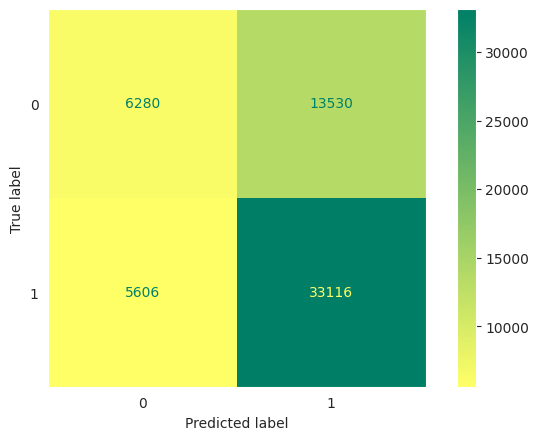

In [12]:
covid_avaliacoes[0] = avaliar_previsoes(y_test, y_pred)

## Modelo 1: SKLearn Random Forest

In [13]:
%%time

set_global_determinism(seed=SEMENTE)

rfc = RandomForestClassifier(n_estimators=50, criterion='gini', bootstrap=True, oob_score=True, warm_start=True, random_state=SEMENTE)

rfc.fit(X_train, y_train)

y_pred = rfc.predict(X_test)

CPU times: user 32.9 s, sys: 178 ms, total: 33 s
Wall time: 40.3 s


              precision    recall  f1-score   support

           0       0.56      0.29      0.38     19810
           1       0.71      0.88      0.79     38722

    accuracy                           0.68     58532
   macro avg       0.63      0.59      0.58     58532
weighted avg       0.66      0.68      0.65     58532



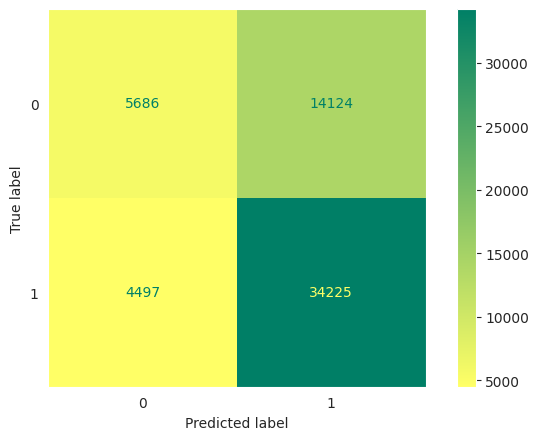

In [14]:
covid_avaliacoes[1] = avaliar_previsoes(y_test, y_pred)

## Modelo 2: SKLearn AdaBoost

In [15]:
%%time

set_global_determinism(seed=SEMENTE)

abc = AdaBoostClassifier(n_estimators=50, learning_rate=1.0, algorithm='SAMME.R', random_state=SEMENTE)

abc.fit(X_train, y_train)

y_pred = abc.predict(X_test)

CPU times: user 12.9 s, sys: 981 ms, total: 13.9 s
Wall time: 13.9 s


              precision    recall  f1-score   support

           0       0.59      0.23      0.33     19810
           1       0.70      0.92      0.79     38722

    accuracy                           0.69     58532
   macro avg       0.65      0.57      0.56     58532
weighted avg       0.66      0.69      0.64     58532



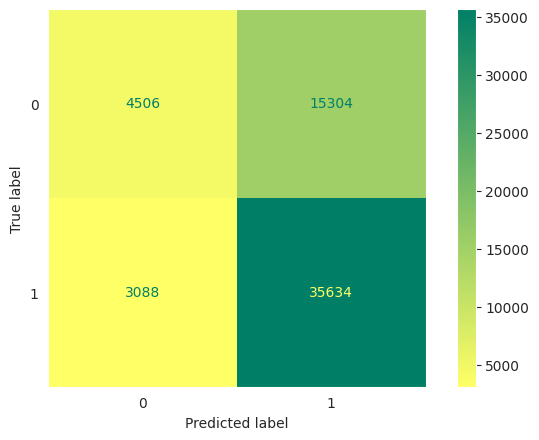

In [16]:
covid_avaliacoes[2] = avaliar_previsoes(y_test, y_pred)

## Modelo 3: SKLearn Gradient Boosting

In [17]:
%%time

set_global_determinism(seed=SEMENTE)

gbc = GradientBoostingClassifier(loss='log_loss', n_estimators=50, learning_rate=1.0, criterion='friedman_mse', warm_start=True, max_depth=3, random_state=SEMENTE)

gbc.fit(X_train, y_train)

y_pred = gbc.predict(X_test)

CPU times: user 22.1 s, sys: 40 ms, total: 22.1 s
Wall time: 22.1 s


              precision    recall  f1-score   support

           0       0.61      0.26      0.36     19810
           1       0.71      0.92      0.80     38722

    accuracy                           0.69     58532
   macro avg       0.66      0.59      0.58     58532
weighted avg       0.67      0.69      0.65     58532



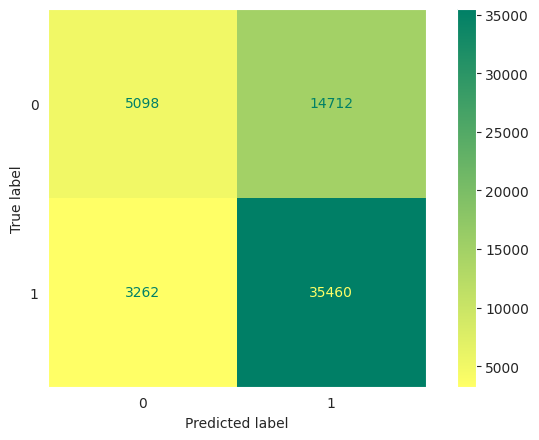

In [18]:
covid_avaliacoes[3] = avaliar_previsoes(y_test, y_pred)

## Modelo 4: XGBoost

In [19]:
%%time

set_global_determinism(seed=SEMENTE)

xgb = XGBClassifier(n_estimators=50, grow_policy='depthwise', learning_rate=0.5, random_state=SEMENTE)

xgb.fit(X_train, y_train)

y_pred = xgb.predict(X_test)

CPU times: user 56.8 s, sys: 167 ms, total: 56.9 s
Wall time: 33.6 s


              precision    recall  f1-score   support

           0       0.61      0.27      0.37     19810
           1       0.71      0.91      0.80     38722

    accuracy                           0.69     58532
   macro avg       0.66      0.59      0.58     58532
weighted avg       0.67      0.69      0.65     58532



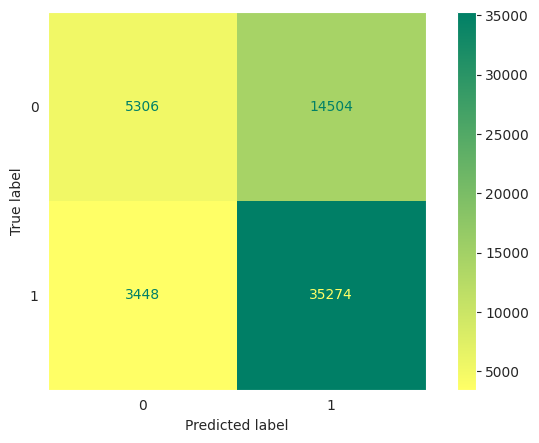

In [20]:
covid_avaliacoes[4] = avaliar_previsoes(y_test, y_pred)

## Modelo 5: TensorFlow Dense

In [21]:
%%time

set_global_determinism(seed=SEMENTE)

tfd = Sequential()

[tfd.add(Dense(units=CAMADA_UNIDADES, kernel_initializer=CAMADA_INICIALIZADOR, activation=CAMADA_ATIVACAO)) for _ in range(CAMADAS)]
tfd.add(Dense(units=SAIDA_UNIDADES, activation=SAIDA_ATIVACAO))

tfd.compile(loss=PERDA,
            optimizer=OTIMIZADOR(learning_rate=APRENDIZADO),
            metrics=METRICAS)

tfd.fit(dataset_train,
        epochs=ITERACOES,
        validation_data=dataset_test,
        verbose=0)

y_pred = tf.round(tfd.predict(dataset_test, verbose=0))

CPU times: user 2min 23s, sys: 3.86 s, total: 2min 27s
Wall time: 1min 43s


              precision    recall  f1-score   support

           0       0.61      0.25      0.36     19810
           1       0.71      0.92      0.80     38722

    accuracy                           0.69     58532
   macro avg       0.66      0.59      0.58     58532
weighted avg       0.67      0.69      0.65     58532



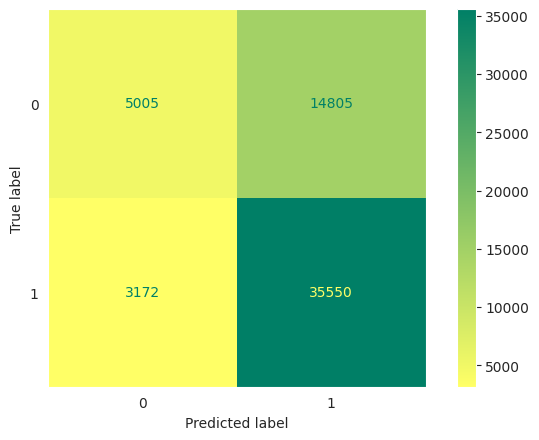

In [22]:
covid_avaliacoes[5] = avaliar_previsoes(y_test, y_pred)

## Modelo 6: TensorFlow Deep

In [23]:
%%time

set_global_determinism(seed=SEMENTE)

tfp = Sequential()

for potencia in range(PROFUNDO_POTENCIA_INICIAL, PROFUNDO_POTENCIA_FINAL):
    unidades = 2 ** potencia
    for _ in range(PROFUNDO_REPETICAO):
        tfp.add(Dense(units=unidades, kernel_initializer=CAMADA_INICIALIZADOR, activation=CAMADA_ATIVACAO))

tfp.add(Dense(units=PROFUNDO_CONSOLIDACAO, activation=CAMADA_ATIVACAO))
tfp.add(Dense(units=SAIDA_UNIDADES, activation=SAIDA_ATIVACAO))

tfp.compile(loss=PERDA,
            optimizer=OTIMIZADOR(learning_rate=APRENDIZADO),
            metrics=METRICAS)

tfp.fit(dataset_train,
        epochs=ITERACOES,
        validation_data=dataset_test,
        verbose=0)

y_pred = tf.round(tfp.predict(dataset_test, verbose=0))

CPU times: user 3min 7s, sys: 3.17 s, total: 3min 10s
Wall time: 2min


              precision    recall  f1-score   support

           0       0.59      0.27      0.37     19810
           1       0.71      0.90      0.79     38722

    accuracy                           0.69     58532
   macro avg       0.65      0.59      0.58     58532
weighted avg       0.67      0.69      0.65     58532



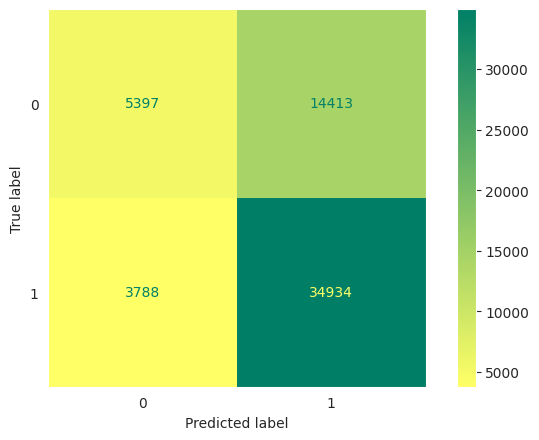

In [24]:
covid_avaliacoes[6] = avaliar_previsoes(y_test, y_pred)

## Modelo 7: TensorFlow Ensemble

In [25]:
%%time

conjunto = obter_conjunto(dados_treino=dataset_train, dados_validacao=dataset_test, q_modelos=5,
                          camadas=CAMADAS, camada_unidades=CAMADA_UNIDADES,
                          camada_inicializador=CAMADA_INICIALIZADOR, camada_ativacao=CAMADA_ATIVACAO,
                          saida_unidades=SAIDA_UNIDADES, saida_ativacao=SAIDA_ATIVACAO,
                          perda=PERDA, otimizador=OTIMIZADOR, aprendizado=APRENDIZADO,
                          metricas=METRICAS, iteracoes=ITERACOES)

Modelo 0 de 5.
Modelo 1 de 5.
Modelo 2 de 5.
Modelo 3 de 5.
Modelo 4 de 5.
CPU times: user 11min 55s, sys: 18.9 s, total: 12min 14s
Wall time: 8min 46s


In [26]:
previsoes = obter_previsoes(conjunto=conjunto, dados_validacao=dataset_test)

y_pred = tf.round(tf.reduce_mean(previsoes, axis=0))

              precision    recall  f1-score   support

           0       0.62      0.25      0.36     19810
           1       0.71      0.92      0.80     38722

    accuracy                           0.69     58532
   macro avg       0.66      0.59      0.58     58532
weighted avg       0.68      0.69      0.65     58532



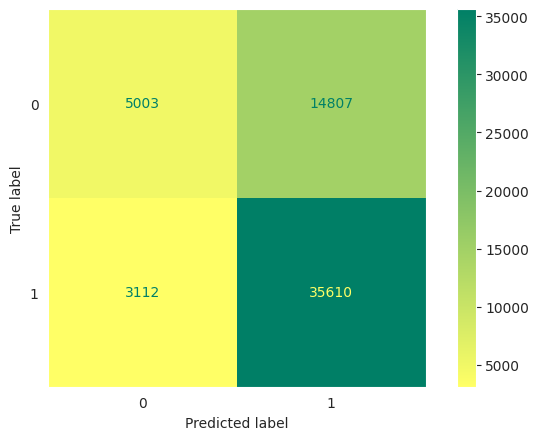

In [27]:
covid_avaliacoes[7] = avaliar_previsoes(y_test, y_pred)

## Comparação de modelos

In [28]:
comparacao = pd.DataFrame([a for a in covid_avaliacoes if a is not None])
comparacao = comparacao.reset_index().melt(id_vars='index').rename(columns=str.title)

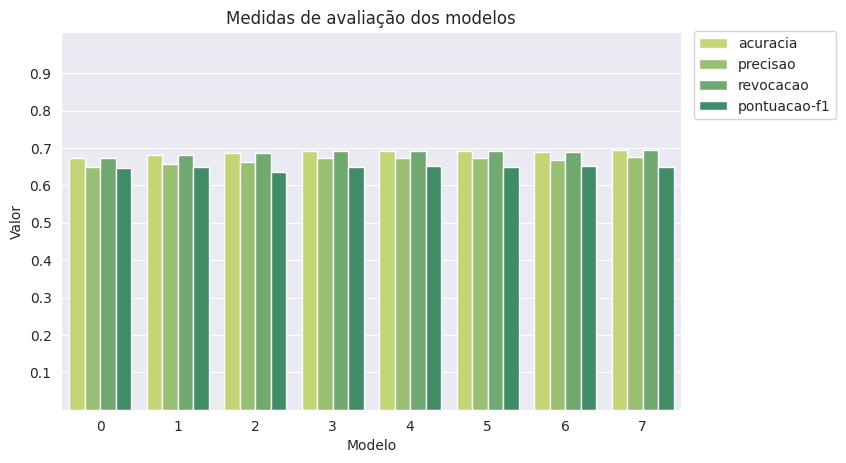

In [29]:
sns.barplot(data=comparacao, x='Index', y='Value', hue='Variable', palette=PALETA)

plt.title('Medidas de avaliação dos modelos')
plt.xlabel('Modelo')
plt.ylabel('Valor')

plt.ylim(0.0, 1.01)
plt.yticks(np.arange(0.1, 1.0, 0.1))

plt.legend(loc=(1.02, 0.77), frameon=True, facecolor='white');